# Thursday Night Football Twitter Analysis

For this project, I wanted to analyse tweets during a Thursday Night Football game. The game that I choose to gather tweets during was November 9th matchup between the Seattle Seahawks vs. Arizona Cardinals.

The hashtags that I used to search twitter were #NFL, #ThursdayNightFootball, #SEAvsAZ, #TNF, #Seahawks, #Cardinals, #WeAre12, #BeRedSeeRed, #BirdGang, #Sea12Hawk.

The twitter listener was started at 7:15pm (about 15 minutes before kick-off) and 11:00pm (a few minutes after the game ended).

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

## Connect to Database

I used a Postgres database to store the tweets and was able to upload the database into a pandas dataframe.

In [2]:
# Connect to database, save in pandas dataframe
conn = psycopg2.connect("dbname=twitter user=meutband")
data = pd.read_sql("SELECT * FROM nfl", conn)

data.to_csv('tweets.csv')

## Cleaning the Database

One of the first things that I chose to look into was the language. The NFL is watched by millions of people across the world and they tweet about it.  

In [3]:
data['language'] = data['tweet'].apply(lambda tweet: TextBlob(tweet).detect_language())

In [4]:
print("Number of languages tweeted: ", len(data['language'].value_counts()))
print(data['language'].value_counts()[:10])

Number of languages tweeted:  62
en    54094
es     1202
pt      682
fr      192
de      152
da      106
ja       79
ar       58
gl       53
id       39
Name: language, dtype: int64


The function below cleans the tweets. Stopwords are removed based on the language

In [5]:
def clean_tweets(df, lang):
        
    # Tokenize the tweets
    tt = TweetTokenizer(strip_handles=True)
    df['tweet'] = df['tweet'].apply(tt.tokenize)
    
    # Remove stopwords    
    languages = {'da':'danish', 'en':'english', 'fr':'french', 
                 'de':'german', 'pt':'portuguese', 'es':'spanish'}
    stop = set(stopwords.words(languages[lang]))
    df['tweet'] = df['tweet'].apply(lambda x: [item.lower() for item in x if item not in stop])
    
    # Remove punctuations
    punc = "`~!@#$%^&*()-_=+[]{}\|;:',<.>/?…"
    df['tweet'] = df['tweet'].apply(lambda x: [item for item in x if item not in punc])
    
    # Remove link from tweet if result is empty list, then drop row
    link = "https://"
    df['tweet'] = df['tweet'].apply(lambda x: [item for item in x if link not in item])
    
    # Create columns of all hastages used and remove hashtags from tweet    
    df['hashtags'] = df['tweet'].apply(lambda x: [item for item in x if '#' in item])
    df['tweet'] = df['tweet'].apply(lambda x: [item for item in x if '#' not in item])
    
    return df

English, Spanish, and Portuguese languages were chosen to filter the datasets based on the number of tweets of each number. (as seen above)

In [6]:
# Create dataframes that contains only the 'language' that contain 500 or more tweets

english = data.loc[data['language'] == 'en']
english = clean_tweets(english, 'en')
english = english.reset_index(drop=True)

spanish = data.loc[data['language'] == 'es']
spanish = clean_tweets(spanish, 'es')
spanish = spanish.reset_index(drop=True)

portuguese = data.loc[data['language'] == 'pt']
portuguese = clean_tweets(portuguese, 'pt')
portuguese = portuguese.reset_index(drop=True)

In [7]:
english.head()

,currenttime,tweet,location,language,hashtags
0,1510276552,"[ready, game]",None,en,"[#seahawks, #gohawks]"
1,1510276553,"[let's, go, boysss, 💚, 💙]",None,en,[#seavsaz]
2,1510276554,"[rt, 🏈, 7:30, pm]",None,en,"[#tnf, #seahawks, #beredseered]"
3,1510276554,"[not, tonight, baby]","Calgary, AB",en,[#seahawks]
4,1510276555,"[primetime, gametime]","Seattle, Washington",en,"[#seavsaz, #gohawks, #seahawks]"


In [8]:
spanish.head()

,currenttime,tweet,location,language,hashtags
0,1510276555,"[rt, así, uniforme, 🤢]",None,es,"[#seahawks, #colorrush]"
1,1510276574,"[rt, sabrosa, noche, jueves, vs, vs, nfl, yes,...","Hermosillo, Sonora",es,"[#allforone, #rockets, #nba, #seahawks, #bered..."
2,1510276605,"[rt, sabrosa, noche, jueves, vs, vs, nfl, yes,...",Mangovy,es,"[#allforone, #rockets, #nba, #seahawks, #bered..."
3,1510276623,"[rt, entra, disfruta, apuesta, vivo]",None,es,[#thursdaynightfootball]
4,1510276677,"[rt, entra, disfruta, apuesta, vivo]",CDMX,es,[#thursdaynightfootball]


In [9]:
portuguese.head()

,currenttime,tweet,location,language,hashtags
0,1510276605,"[taima, falcão, lindo, porra]",None,pt,"[#seahawks, #weare12, #gohawks, #nflnaespn]"
1,1510276617,"[vamos, palpites]",None,pt,"[#tnf, #seahawks, #beredseered, #nflnaespn]"
2,1510276638,"[taima, merece, anel, super, bowl, 😍, ❤]",None,pt,"[#nflnaespn, #seahawks]"
3,1510276664,"[vitória, hj, pra, entrar, briga, pro, playoff...",Castilho-SP,pt,"[#nflnaespn, #beredseered]"
4,1510276688,"[rt, taima, merece, anel, super, bowl, 😍, ❤]",USS ENTERPRISE,pt,"[#nflnaespn, #seahawks]"


## Creating WordClouds

The function below creates the WordCloud image.
- The WordCloud function calls for strings as inputs. Therefore the tweets columns needed to be joined together.

In [10]:
def cloud(df, col='tweet', coll=True):
    
    # input col to see difference column
    # coll input is for collocations parameter inside WordCount
        #i.e. Whether to include collocations (bigrams) of two words.
    
    # join tweets into string
    text = ' '.join(df[col].str.join(' '))
    
    # WordCloud implementation
    wc = WordCloud(background_color="white", collocations=coll)
    wc.generate(text)
    
    # Show figure
    plt.figure(figsize=(8,8))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

Create clouds for each of the languages chosen.

English


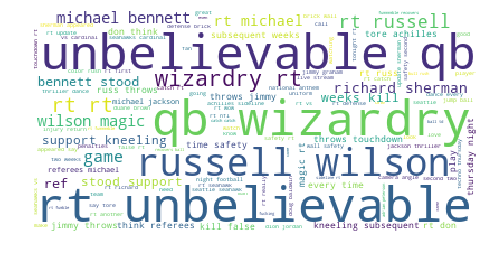

Spanish


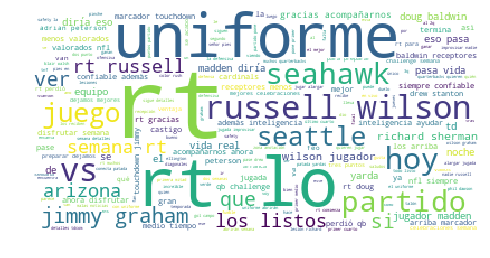

Portuguese


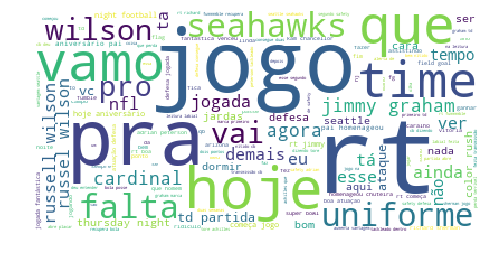

In [11]:
print("English")
cloud(english)
print("Spanish")
cloud(spanish)
print("Portuguese")
cloud(portuguese)

As you can see in the WordClouds above, retweets (labeled as 'rt') were a mashive contributor to the counts. In order to minimize the impact of 'rt', I choose to separate retweets from their original tweet.

The function below separates into retweets and original tweets.
- 'rt' is removed from the tweet once the retweet is separated

In [12]:
# Create separate dataframes for original tweets and retweets, remove rt from retweets

def separate_dataframes(df):

    orig = pd.DataFrame(columns=list(df))
    ret = pd.DataFrame(columns=list(df))

    # if 'rt' in tweet then add to ret df
    for i in range(df.shape[0]):
        if 'rt' in df['tweet'][i]:
            ret = ret.append(df.loc[[i]])
        else:
            orig = orig.append(df.loc[[i]])
    
    # remove 'rt' from tweets
    ret['tweet'] = ret['tweet'].apply(lambda x: [item for item in x if item != 'rt'])
    
    return ret, orig

Create retweet and original dataframes for each language

In [13]:
eng_ret, eng_or = separate_dataframes(english)
sp_ret, sp_or = separate_dataframes(spanish)
port_ret, port_or = separate_dataframes(portuguese)

English Retweets


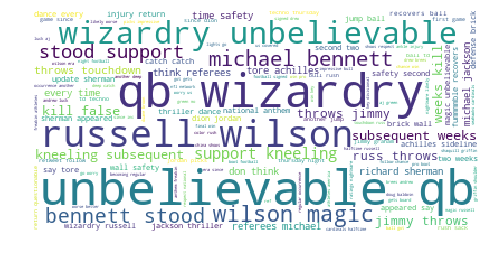

English Originals


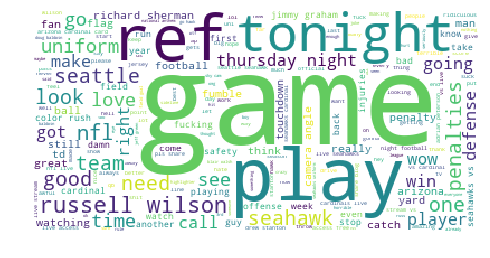

In [14]:
print("English Retweets")
cloud(eng_ret)
print("English Originals")
cloud(eng_or)

Spanish Retweets


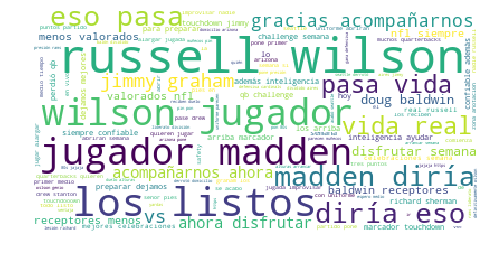

Spanish Originals


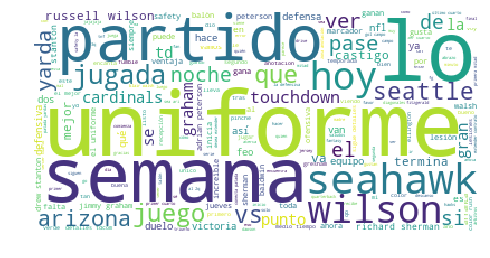

In [15]:
print("Spanish Retweets")
cloud(sp_ret)
print("Spanish Originals")
cloud(sp_or)

Portuguese Retweets


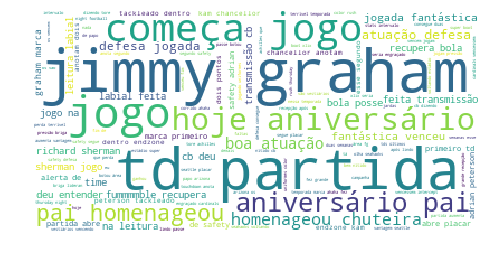

Portuguse Originals


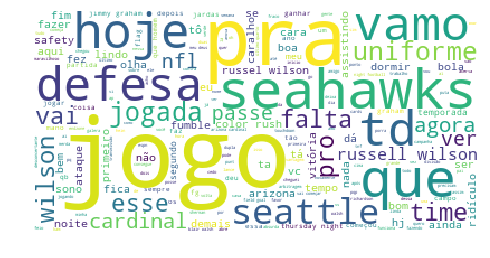

In [16]:
print("Portuguese Retweets")
cloud(port_ret)
print("Portuguse Originals")
cloud(port_or)

### Creating WordClouds, pt 2

Create WordCloud that shows the usage of hashtags in the tweets. 

English Hastags


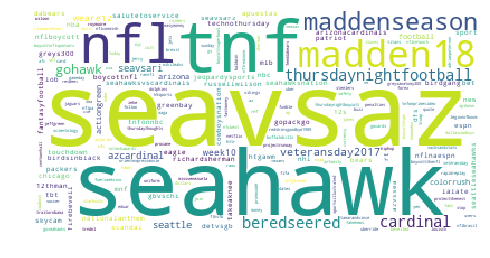

Spanish Hastags


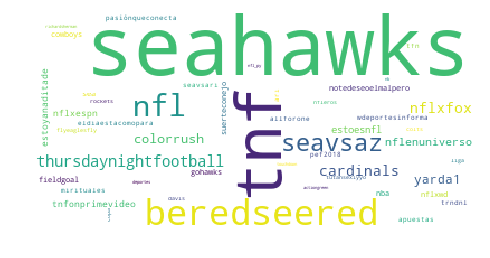

Portuguese Hastags


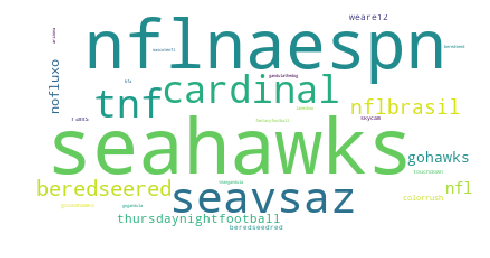

In [17]:
print("English Hastags")
cloud(english, col='hashtags', coll=False)
print("Spanish Hastags")
cloud(spanish, col='hashtags', coll=False)
print("Portuguese Hastags")
cloud(portuguese, col='hashtags', coll=False)